In [1]:
%matplotlib notebook

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpmath import polylog

import scipy 
from scipy import sparse
from scipy.sparse import linalg as spla

In [2]:
def build_generator(N, Vd_o_Vth, qe_o_qth, n=1, dense=False, half=False):
    
    g = np.exp(-Vd_o_Vth-qe_o_qth/2)
    
    lpn = lambda q1, q2: np.exp((Vd_o_Vth + q2*qe_o_qth)/n)
    lmn = lambda q1, q2: lpn(q1, q2)*g*np.exp(-q1*qe_o_qth)
        
    lpp = lambda q1, q2: np.exp((Vd_o_Vth - q2*qe_o_qth)/n)
    lmp = lambda q1, q2: lpp(q1, q2)*g*np.exp(q1*qe_o_qth)
    
    A = lambda q1, q2: lpp(q1, q2) + lmn(q1, q2) # rate for a transition q ->  q + qe
    B = lambda q1, q2: lmp(q1, q2) + lpn(q1, q2) # rate for a transition q ->  q - qe
    
    rows = []
    cols = []
    data = []
    
    if half:
        R1 = range(0,N+1)
        L1 = N+1
        map_ind = lambda q1, q2: q1 + L1*(N+q2)
    else:
        R1 = range(-N,N+1)
        L1 = 2*N+1
        map_ind = lambda q1, q2: N+q1 + L1*(N+q2)
    
    for q1 in R1:
        for q2 in range(-N,N+1):
            
            ind = map_ind(q1, q2)
            
            if half:
                esc = B(q1, q2)
            else:
                esc = 0
              
            # arrival from or escape to q1-qe
            if (not half and q1-1 >= -N) or (half and q1-1 >= 0):
                aux = map_ind(q1-1, q2)
                
                arr = A(q1-1, q2)
                
                if not half:
                    esc += B(q1, q2)

                rows.append(ind)
                cols.append(aux)
                data.append(arr)
                           
            # arrival from or escape to q1+qe
            if q1+1 <= N:
                aux = map_ind(q1+1, q2)

                arr = B(q1+1, q2)
                esc += A(q1, q2)
                
                rows.append(ind)
                cols.append(aux)
                data.append(arr)
 
                
            # arrival from or escape to q2-qe
            if q2-1 >= -N:
                aux = map_ind(q1, q2-1)

                arr = A(q2-1, q1)
                esc += B(q2, q1)

                rows.append(ind)
                cols.append(aux)
                data.append(arr)

                
            # arrival from or escape to q2+qe
            if q2+1 <= N:
                aux = map_ind(q1, q2+1)
                
                arr = B(q2+1, q1)
                esc += A(q2, q1)

                rows.append(ind)
                cols.append(aux)
                data.append(arr)

            # escape rate
        
            rows.append(ind) 
            cols.append(ind)
            data.append(-esc)                
    
    if dense:
        gen = np.zeros((L1*(2*N+1), L1*(2*N+1)))
        for r, c, d in zip(rows, cols, data):
            gen[r,c] = d
    else:          
        gen = sparse.coo_matrix((data, (rows, cols)))
    
    return gen


def decode_ss(ss, norm=True):
    
    if norm:
        ss = ss/np.sum(ss)
    
    N = int((np.sqrt(len(ss))-1)/2)
    
    P = np.zeros((2*N+1,2*N+1))
    
    for k in range(len(ss)):
        
        q2 = int(k/(2*N+1)) - N
        q1 = k%(2*N+1) - N
        
        P[N+q1,N+q2] = ss[k][0]
        
    return P

def var_change(P):
    
    N = int((P.shape[0]-1)/2)
    Q = np.zeros((4*N+1,4*N+1))
    
    print(N,Q.shape)
    
    for q1 in range(-N,N+1):
        for q2 in range(-N,N+1):
            
            d = q1 - q2
            s = q1 + q2 
            
            Q[2*N+d, 2*N+s] += P[N+q1,N+q2]
            
    
    return Q

def make_product(P):
    
    P0 = np.sum(P, axis=0)
    P1 = np.sum(P, axis=1)
    
    Q = np.zeros_like(P)
    
    N = int((P.shape[0]-1)/2)

    for q1 in range(-N,N+1):
        for q2 in range(-N,N+1):
            Q[N+q1, N+q2] = P1[N+q1]*P0[N+q2]

    return Q

def exact_g(V, Vd, n):

    if hasattr(V, '__iter__'):
        PLA = np.array([float(polylog(2,-np.exp(Vd+x*(1+2/n)))) for x in V])
        PLB = np.array([float(polylog(2,-np.exp(-Vd+x*(1+2/n)))) for x in V])
    else:
        PLA = float(polylog(2,-np.exp(Vd+V*(1+2/n))))
        PLB = float(polylog(2,-np.exp(-Vd+V*(1+2/n))))
        
    g = V*(2*Vd+V)
    g += (2*n/(n+2))*PLA
    g -= (2*n/(n+2))*PLB
    
    return g

def effective_potential_g(x, vd, slope=1):
    
    lpp = lambda v1, v2: np.exp((vd-v2)/slope)
    lmp = lambda v1, v2: lpp(v1, v2)*np.exp(-(vd-v1))

    lpn = lambda v1, v2: np.exp((vd+v2)/slope)
    lmn = lambda v1, v2: lpn(v1, v2)*np.exp(-(vd+v1))
    
    Am = lambda v1, v2: lpp(v1,v2) + lmn(v1,v2)
    Ap = lambda v1, v2: lmp(v1,v2) + lpn(v1,v2)
    
    
    alpha = (Am(-x,x) + Ap(x,-x))/(Am(x,-x) + Ap(-x,x))
    
    return 2*np.log(alpha)

def effective_potential_h(y, vd, xmin=0, slope=1):
    
    lpp = lambda v1, v2: np.exp((vd-v2)/slope)
    lmp = lambda v1, v2: lpp(v1, v2)*np.exp(-(vd-v1))

    lpn = lambda v1, v2: np.exp((vd+v2)/slope)
    lmn = lambda v1, v2: lpn(v1, v2)*np.exp(-(vd+v1))
    
    Am = lambda v1, v2: lpp(v1,v2) + lmn(v1,v2)
    Ap = lambda v1, v2: lmp(v1,v2) + lpn(v1,v2)
    
    v1 = xmin + y
    v2 = -xmin + y
    
    beta = (Ap(xmin + y,-xmin + y) + Ap(-xmin + y,xmin + y))/(Am(xmin + y,-xmin + y) + Am(-xmin + y,xmin + y))
    
    return 2*np.log(beta)


def average_currents(P,Vd_o_Vth, qe_o_qth, n=1):
    
    g = np.exp(-Vd_o_Vth-qe_o_qth/2)
    
    lpn = lambda q1, q2: np.exp((Vd_o_Vth + q2*qe_o_qth)/n)
    lmn = lambda q1, q2: lpn(q1, q2)*g*np.exp(-q1*qe_o_qth)
        
    lpp = lambda q1, q2: np.exp((Vd_o_Vth - q2*qe_o_qth)/n)
    lmp = lambda q1, q2: lpp(q1, q2)*g*np.exp(q1*qe_o_qth)
    
    
    N = int((P.shape[0]-1)/2)
    
    In = Ip = 0
           
    for q1 in range(-N,N+1):
        for q2 in range(-N,N+1):
            
            In += (lpn(q1,q2) - lmn(q1,q2))*P[N+q1,N+q2]
            Ip += (lpp(q1,q2) - lmp(q1,q2))*P[N+q1,N+q2]
            
    return In, Ip


def approx_g_1st(V, Vd, n):

    g = V**2 - 4*Vd*(n/(n+2))*np.log(2*np.cosh((V/2)*(n+2)/n))
    
    return g

<IPython.core.display.Javascript object>


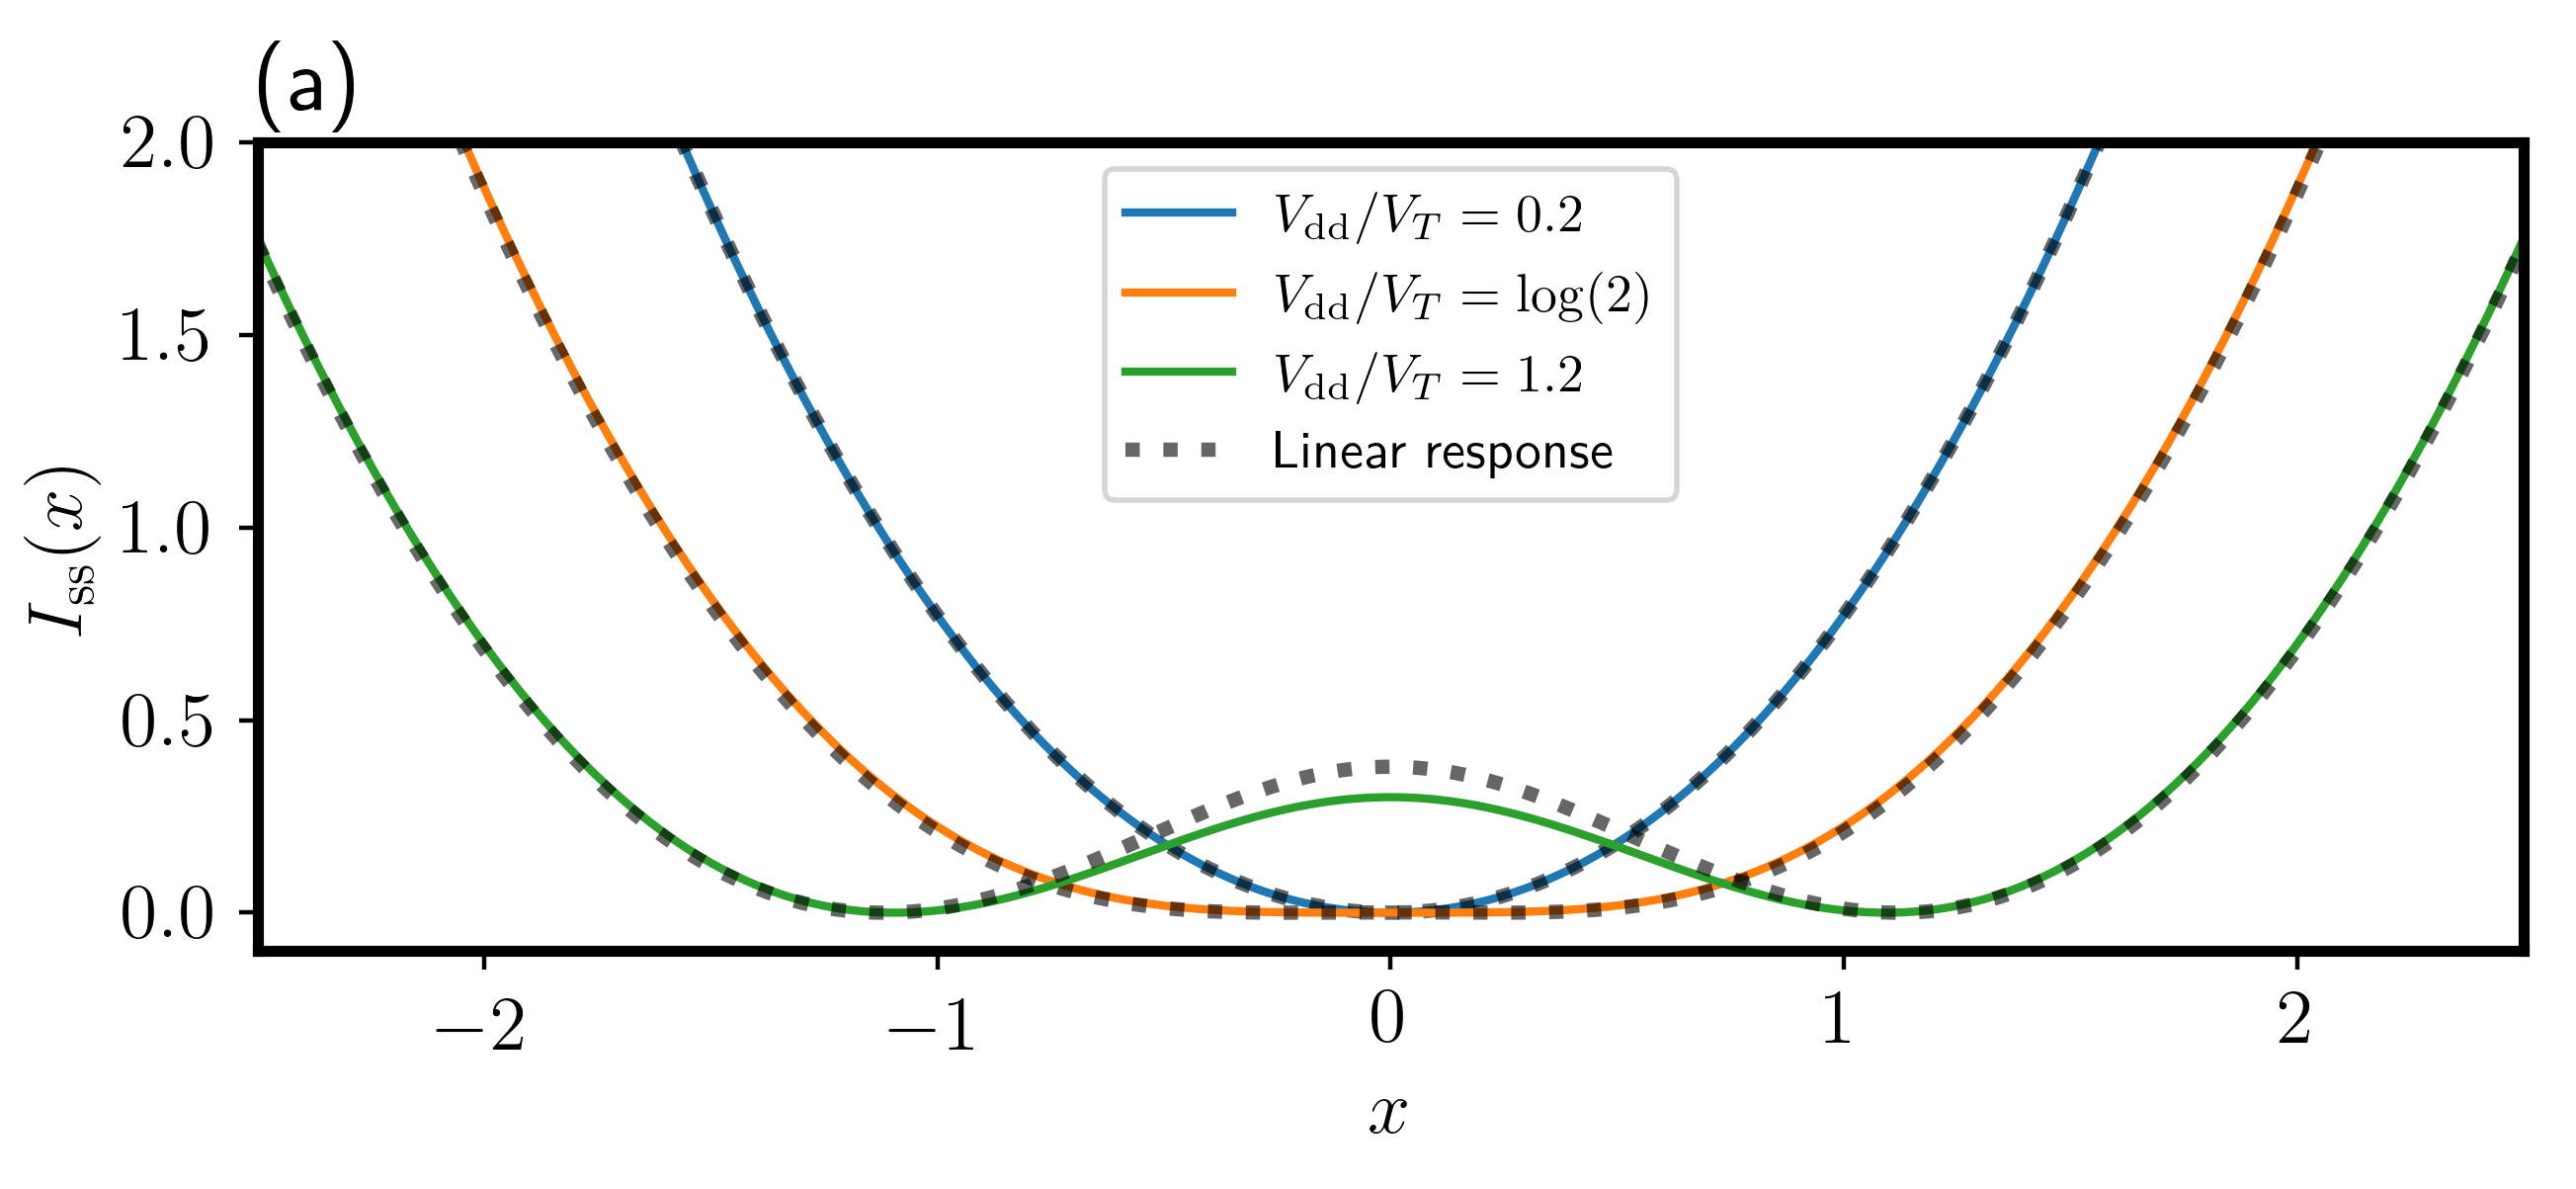

In [4]:
#Direct input 
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'sans-serif',
          }
plt.rcParams.update(params)

# f, ax = plt.subplots(1, 1, sharex=True, figsize=(6.5,3), dpi=401)
# plt.gcf().subplots_adjust(right=.98,left=0.1,hspace=.18, bottom=.2)
# plt.setp(ax.spines.values(), linewidth=2)
    
# ax.bar(.5*ve*qd, np.sum(Q, axis=1), width=ve/2)
# Pg = np.exp(-(g-np.min(g)))#[1000:-1000]
# Pg = Pg/np.sum(Pg)
# ax.plot(v, Pg*len(v)/(2*N+1), color='C1', linewidth=2)
# #ax.set_xlim(-2.5,2.5)
# #ax.set_xlabel(r'$x/V_T$')
# ax.set_ylabel(r'$\log_{10} P(x)$')
# ax.legend([r"$P(x) \propto \exp(-\Omega I_\mathrm{ss}(x))$", "Exact"], fontsize='x-small', loc='upper right')
# ax.set_yscale('log')


# ax.set_xlabel('$x$')
# ax.set_xlim(-2.5,2.5)
# ax.set_ylim(5e-5,1)
# ax.set_yticks([1e-1, 1e-3])
# ax.set_yticklabels(['-1', '-3'])



f, ax = plt.subplots(1, 1, sharex=True, figsize=(6.5,3), dpi=401)
plt.gcf().subplots_adjust(right=.98,left=0.1,hspace=.18, bottom=.2)
plt.setp(ax.spines.values(), linewidth=2)

auxv = np.linspace(-2.5, 2.5, 20000)
dg = effective_potential_g(auxv, .2)
auxg = np.cumsum(dg)*(auxv[1]-auxv[0])/1#qe_o_qth # note, that qe_o_qth is the same as ve_o_vth
ax.plot(auxv, auxg-np.min(auxg), color='C0', label=r"$V_\mathrm{dd}/V_T = 0.2$")

auxg = approx_g_1st(auxv, .2, n=1)
ax.plot(auxv, auxg-np.min(auxg),':', color='black', linewidth=2.6, alpha=.6)


dg = effective_potential_g(auxv, np.log(2))
auxg = np.cumsum(dg)*(auxv[1]-auxv[0])/1#qe_o_qth # note, that qe_o_qth is the same as ve_o_vth
ax.plot(auxv, auxg-np.min(auxg), color='C1', label=r"$V_\mathrm{dd}/V_T = \log(2)$")

auxg = approx_g_1st(auxv, np.log(2), n=1)
ax.plot(auxv, auxg-np.min(auxg),':', color='black', linewidth=2.6, alpha=.6)

dg = effective_potential_g(auxv, 1.2)
auxg = np.cumsum(dg)*(auxv[1]-auxv[0])/1#qe_o_qth # note, that qe_o_qth is the same as ve_o_vth
ax.plot(auxv, auxg-np.min(auxg), color='C2', label=r"$V_\mathrm{dd}/V_T = 1.2$")

auxg = approx_g_1st(auxv, 1.2, n=1)
ax.plot(auxv, auxg-np.min(auxg),':', color='black', linewidth=2.6, alpha=.6, label='Linear response')





#ax.legend([r"$V_\mathrm{dd}/V_T = 0.2$", r"$V_\mathrm{dd}/V_T = \ln(2)$", r"$V_\mathrm{dd}/V_T = 1.2$", "Linear response"], loc='upper center', fontsize='x-small')
ax.legend(loc='upper center', fontsize='x-small')


ax.set_ylabel('$I_\mathrm{ss}(x)$')
ax.set_xlabel('$x$')
ax.set_xlim(-2.5,2.5)
ax.set_ylim(-.1,2)

plt.title('(a)', loc='left')
plt.savefig('rate_func_1.pdf')



